In [1]:
import praw
import creds

reddit = praw.Reddit(
    client_id=creds.CLIENT_ID,
    client_secret=creds.CLIENT_SECRET,
    user_agent=creds.USER_AGENTS
)


In [2]:
import pandas as pd
from datetime import datetime, timedelta

subreddits = ["moving", "florida", "realestate", "homeowners", "personalfinance"]
keywords = ["moving to Florida", "relocating to Florida", "Florida housing market", 
            "Florida job market", "Florida cost of living", "Florida taxes"]

def fetch_posts(subreddit, query, time_filter="year", limit=500):
    posts = []
    for submission in reddit.subreddit(subreddit).search(query, time_filter=time_filter, limit=limit):
        posts.append({
            "subreddit": subreddit,
            "title": submission.title,
            "selftext": submission.selftext,
            "created_utc": datetime.utcfromtimestamp(submission.created_utc),
            "upvotes": submission.score,
            "num_comments": submission.num_comments,
            "url": submission.url
        })
    return posts

# Collect data from multiple subreddits
all_posts = []
for sub in subreddits:
    for kw in keywords:
        all_posts.extend(fetch_posts(sub, kw, time_filter="all", limit=500))

df = pd.DataFrame(all_posts)
df.to_csv("florida_migration_reddit.csv", index=False)

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download("punkt_tab")

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\W+', ' ', text.lower())  # Remove special characters
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

df["clean_text"] = df["title"] + " " + df["selftext"]
df["clean_text"] = df["clean_text"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


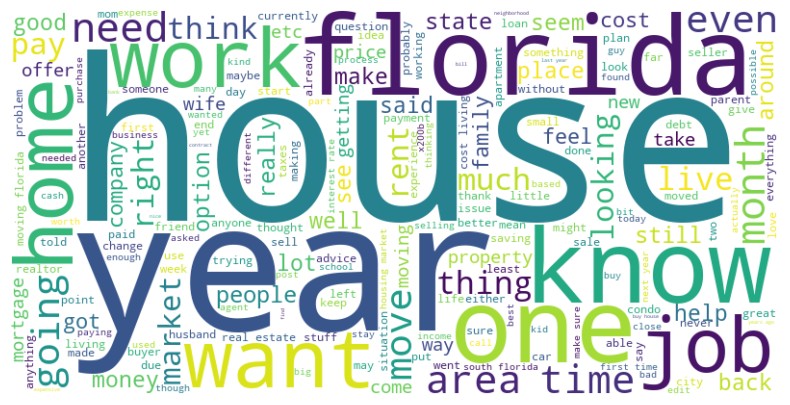

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df["clean_text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df["clean_text"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}: ", [terms[i] for i in topic.argsort()[-10:]])


Topic 1:  ['state', 'people', 'looking', 'living', 'want', 'live', 'moving', 'job', 'like', 'florida']
Topic 2:  ['law', 'weeks', 'storm', 'home', 'plan', 'hurricanes', 'state', 'moving', 'insurance', 'florida']
Topic 3:  ['like', 'agent', 'offer', 'know', 'home', 'company', 'said', 'new', 'time', 'house']
Topic 4:  ['debt', 'years', 'florida', 'tax', 'car', 'income', 'money', 'pay', 'year', 'month']
Topic 5:  ['years', 'property', 'mortgage', 'florida', 'buy', 'sell', 'rent', 'market', 'home', 'house']


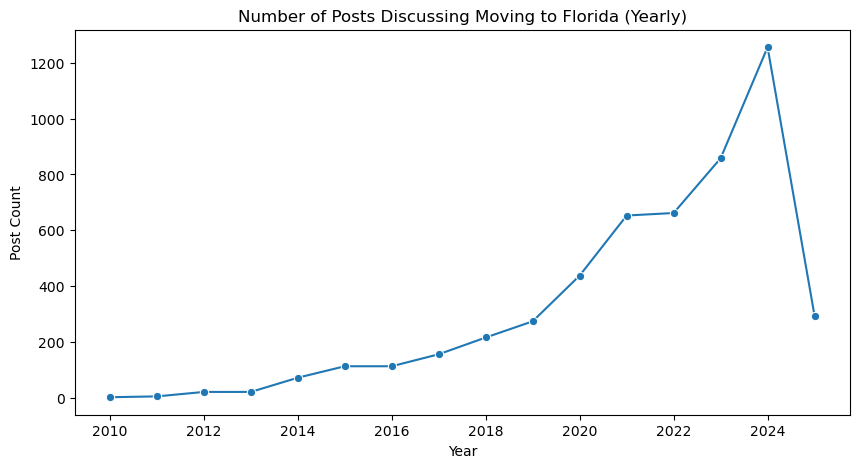

In [6]:
import seaborn as sns

df["year"] = df["created_utc"].dt.year
df_yearly = df.groupby("year").size().reset_index(name="post_count")

plt.figure(figsize=(10,5))
sns.lineplot(data=df_yearly, x="year", y="post_count", marker="o")
plt.title("Number of Posts Discussing Moving to Florida (Yearly)")
plt.xlabel("Year")
plt.ylabel("Post Count")
plt.show()


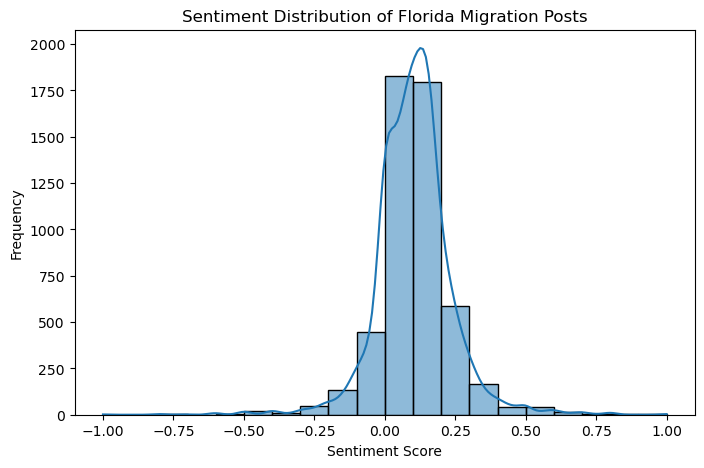

In [7]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df["sentiment"] = df["clean_text"].apply(get_sentiment)

plt.figure(figsize=(8,5))
sns.histplot(df["sentiment"], bins=20, kde=True)
plt.title("Sentiment Distribution of Florida Migration Posts")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


In [8]:
from prophet import Prophet

# Aggregate post count by month
df["month"] = df["created_utc"].dt.to_period("M").astype(str)
df_monthly = df.groupby("month").size().reset_index(name="post_count")

# Rename columns for Prophet
df_monthly.rename(columns={"month": "ds", "post_count": "y"}, inplace=True)
df_monthly["ds"] = pd.to_datetime(df_monthly["ds"])  # Convert to datetime format

# Display first few rows
df_monthly.head()

,ds,y
0,2010-11-01,2
1,2011-06-01,1
2,2011-08-01,3
3,2011-12-01,1
4,2012-01-01,3


In [9]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_monthly)

# Create a dataframe with future dates (next 12 months)
future = model.make_future_dataframe(periods=12, freq="M")

# Generate forecast
forecast = model.predict(future)

# Show forecasted data
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

08:17:23 - cmdstanpy - INFO - Chain [1] start processing
08:17:24 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
162,2025-10-31,104.966838,89.635787,120.181847
163,2025-11-30,97.387986,82.450132,111.818072
164,2025-12-31,103.878600,87.247127,119.721028
165,2026-01-31,113.562095,98.039942,129.485457
166,2026-02-28,137.778843,121.558462,153.566221


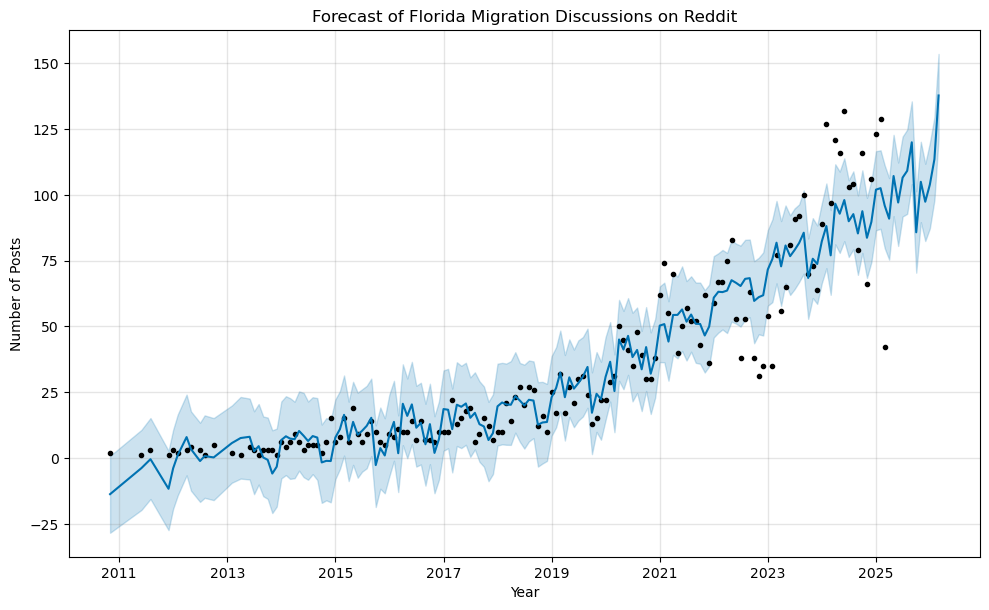

In [10]:
import matplotlib.pyplot as plt

# Plot the forecast
fig = model.plot(forecast)
plt.title("Forecast of Florida Migration Discussions on Reddit")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.show()

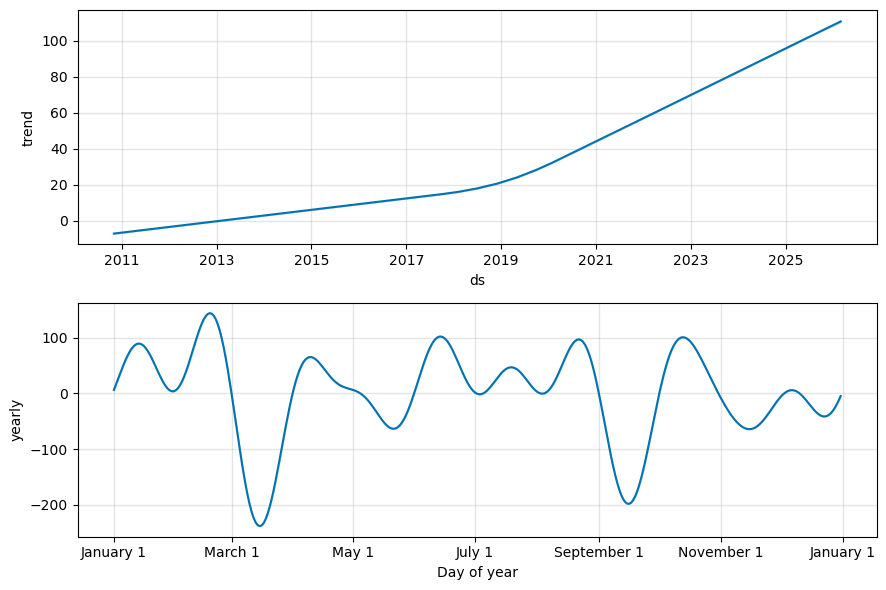

In [11]:
fig2 = model.plot_components(forecast)
plt.show()